**MELI DATA CHALLENGE 2019 - EDA**
================================
**Description:** 

This notebook is intended to explore and analyze the data available for the modeling, in order to discover insights that could lead to a proper treatment of the data for the preprocessing and the modelings steps to implement.

**Goal:**    
In particular, these are the aspects to be analyzed:

- Categories to predict (number and kind)
- Discover ways to prepare the data for the modeling
- Strategy for cross-validation


In [1]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns
import unidecode
from wordcloud import WordCloud

np.random.seed(123)
pd.set_option('display.max_rows', 100)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Load dataset

The dataset provided contains all the available information to use to obtain the model. Therefore, further split is required to implement a cross-validation strategy.

> NOTE: no data dictionary was available, so we need to explore the meaning of each column.

In [2]:
df = pd.read_csv("../data/train.csv")
print(f"DataFrame has {df.shape[0]} rows and the following columns: {list(df.columns)}")
df

DataFrame has 20000000 rows and the following columns: ['title', 'label_quality', 'language', 'category']


,title,label_quality,language,category
0,Hidrolavadora Lavor One 120 Bar 1700w Bomba A...,unreliable,spanish,ELECTRIC_PRESSURE_WASHERS
1,Placa De Sonido - Behringer Umc22,unreliable,spanish,SOUND_CARDS
2,Maquina De Lavar Electrolux 12 Kilos,unreliable,portuguese,WASHING_MACHINES
3,Par Disco De Freio Diant Vent Gol 8v 08/ Frema...,unreliable,portuguese,VEHICLE_BRAKE_DISCS
4,Flashes Led Pestañas Luminoso Falso Pestañas P...,unreliable,spanish,FALSE_EYELASHES
...,...,...,...,...
19999995,Brochas De Maquillaje Kylie Set De 12 Unidades,unreliable,spanish,MAKEUP_BRUSHES
19999996,Trimmer Detailer Wahl + Kit Tijeras Stylecut,reliable,spanish,HAIR_CLIPPERS
19999997,Bateria Portátil 3300 Mah Power Bank Usb Max...,unreliable,portuguese,PORTABLE_CELLPHONE_CHARGERS
19999998,"Palo De Hockey Grays Nano 7 37,5''",unreliable,spanish,FIELD_HOCKEY_STICKS


In [3]:
# Check nans
df.isna().any(axis=1).any(axis=0)

False

✔There are no nans to filter

In order to make a quick EDA, a sample of the data will be analyzed. To get a representative sample to analyze a classification problem, stratification will be done by categories.

In [4]:
ratio = 0.02
df = df.groupby("category", group_keys=False).apply(lambda d: d.sample(n=int(len(d) * ratio)))
print(f"DataFrame sampled has shape {df.shape}")
df

DataFrame sampled has shape (399219, 4)


,title,label_quality,language,category
567166,Óculos Box 2.0 3d Android Ios Controle Preço T...,unreliable,portuguese,3D_GLASSES
17814839,Super Óculos 3d Sony - Promoção,unreliable,portuguese,3D_GLASSES
18192638,Lentes 3d Importados,unreliable,spanish,3D_GLASSES
13037924,Hombres Mujeres Gafas De Protección Moda Prote...,unreliable,spanish,3D_GLASSES
3732721,3 X Lentes Clip-on 3d Cinema Sobrepor Oculos D...,unreliable,portuguese,3D_GLASSES
...,...,...,...,...
10562776,Yogurtera Antigua Batilux Con Caja Y Manual,unreliable,spanish,YOGURT_MAKERS
10653564,Cuotas S/int! Yogurtera Atma Ym3010e Digital 7...,unreliable,spanish,YOGURT_MAKERS
19907444,"Iogurteira Elétrica 1,6 Lts 220v Com Detalhe L...",unreliable,portuguese,YOGURT_MAKERS
6386938,Yogurtera Mackenna,unreliable,spanish,YOGURT_MAKERS


We could extract the following data dictionary:
- **title:** Description of item published in the plaform
- **language:** Language of the title of the item published
- **label_quality:** Flag to indicate if the quality of the label assigned is reliable or not
- **category:** Categorical value assigned to item based on some nomenclature.

This dataset contains one record per item published in the e-commerce platform, and the goal is to predict the value of "category" based on the available info of the item.

### > Check "language"

Since each language has different words (with different meanings), and even the notion of brands and categories could differ between languages, **a first assumption is made here: the approach will handle one model per language**.      

Let's check the distribution of rows per language. 

<AxesSubplot:xlabel='language', ylabel='count'>

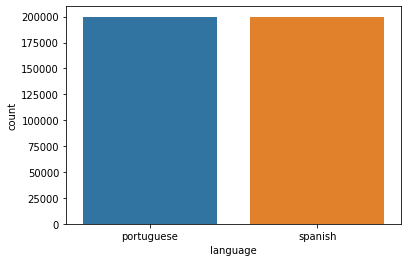

In [5]:
sns.countplot(x="language", data=df)

✔ Same amount of records per language, so every model will receive similar quantity of information.

### > Check "category"

Let's review the distribution of the values to predict to understand the target variable

In [6]:
df["category"].value_counts(normalize=True) * 100.

PANTS                                   0.180102
COFFEE_MAKERS                           0.175843
BABY_CAR_SEATS                          0.171084
MUSICAL_KEYBOARDS                       0.166325
MATTRESSES                              0.165072
                                          ...   
FORCE_GAUGES                            0.001002
PAINTBALL_SMOKE_GRENADES                0.000751
COLD_FOOD_AND_DRINK_VENDING_MACHINES    0.000751
HAMBURGER_FORMERS                       0.000501
COMMERCIAL_POPCORN_MACHINES             0.000501
Name: category, Length: 1588, dtype: float64

<AxesSubplot:xlabel='category', ylabel='Count'>

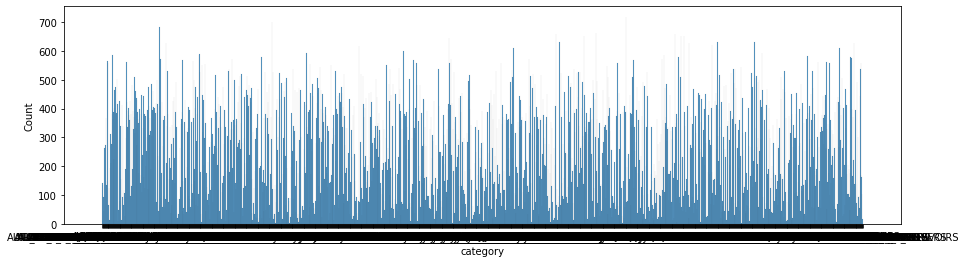

In [7]:
plt.figure(figsize=(15,4))
sns.histplot(x="category", data=df)

✔ There are +1k classes to predict, so the model must be able to handle this  
✔ Categories are strings, so an encoding to integers in range [0, N-1] must be done for the machine learning task  
✔ Some categories seems to be related in abstracts classes (e.g. machines, clothes, etc), but for this task they will be treated independently.  
✔ There is some imbalance of classes in terms of categories having very few records (maybe a min coverage must be required to include a class)

### Cross-validation strategy

Based on the assumption of one model per language, and the distribution of categories analyzed, this is the proposal for the cross-validation:
- Split datasets per language (spanish and portuguese)
- Train / Test split of the whole dataset
- During modeling, Train is split into Train / Valid
- IMPORTANT: split must be stratified per categories, to ensure a similar balance of classes on each dataset.  

### > Check "label_quality"

Let's review the meaning of this attribute to see how it could be used.

In [8]:
pd.crosstab(index=df["language"], columns=df["label_quality"], values=df["label_quality"], aggfunc="count", normalize="index")

label_quality,reliable,unreliable
language,,
portuguese,0.070156,0.929844
spanish,0.049311,0.950689


✔ Must of the items have label quality unreliable, especially the items in spanish. 

In [9]:
df[df["label_quality"] == "reliable"]

,title,label_quality,language,category
11825417,Duplicator 7 Plus V1.5 (nova) Pronta Entrega,reliable,portuguese,3D_PRINTERS
677256,Impresora Chimak 3d 101 Oportunidad!!!,reliable,spanish,3D_PRINTERS
13604842,Geeetech Aluminio Impresora 3d Kits Marco Fuer...,reliable,spanish,3D_PRINTERS
1871772,Impresora 3d Delta Gigante (18 X 32cm) Con Lec...,reliable,spanish,3D_PRINTERS
8211131,Impresora 3d Big-t,reliable,spanish,3D_PRINTERS
...,...,...,...,...
18195116,10 Novelos Barbante Barroco Maxcolor 4 Crochê ...,reliable,portuguese,YARNS
15022672,Mat Yoga Pilates Violeta,reliable,spanish,YOGA_MATS
5234839,Mat Gigante 182 Mm X 122 Mm X 6 Mm Gorilla Ma...,reliable,spanish,YOGA_MATS
1326259,Maquina Para Yogurt Y Quesos Cuisinart,reliable,spanish,YOGURT_MAKERS


In [10]:
df[df["label_quality"] == "unreliable"]

,title,label_quality,language,category
567166,Óculos Box 2.0 3d Android Ios Controle Preço T...,unreliable,portuguese,3D_GLASSES
17814839,Super Óculos 3d Sony - Promoção,unreliable,portuguese,3D_GLASSES
18192638,Lentes 3d Importados,unreliable,spanish,3D_GLASSES
13037924,Hombres Mujeres Gafas De Protección Moda Prote...,unreliable,spanish,3D_GLASSES
3732721,3 X Lentes Clip-on 3d Cinema Sobrepor Oculos D...,unreliable,portuguese,3D_GLASSES
...,...,...,...,...
4879392,Apostila Receitas De Geléias Artesanais Com Fr...,unreliable,portuguese,YOGURT_MAKERS
10562776,Yogurtera Antigua Batilux Con Caja Y Manual,unreliable,spanish,YOGURT_MAKERS
10653564,Cuotas S/int! Yogurtera Atma Ym3010e Digital 7...,unreliable,spanish,YOGURT_MAKERS
19907444,"Iogurteira Elétrica 1,6 Lts 220v Com Detalhe L...",unreliable,portuguese,YOGURT_MAKERS


✔ From a simple inspection, no big differences found in titles for items with different label_quality   
✔ Due to the lack of information and confidence of this attribute, **the model will only use title information to make the predictions**

### > Check "title"

This is the main information to use to predict categories, so good preparation of the text is required to make the model able to learn correctly from the text.

Let's do a simple inspection per language first.

In [11]:
df[df["language"] == "spanish"]

,title,label_quality,language,category
18192638,Lentes 3d Importados,unreliable,spanish,3D_GLASSES
13037924,Hombres Mujeres Gafas De Protección Moda Prote...,unreliable,spanish,3D_GLASSES
11040870,Lentes 3d Samsung 4100 Originales En Caja Ofer...,unreliable,spanish,3D_GLASSES
5337292,Lentes Lg Dual Play Ag-f310dp,unreliable,spanish,3D_GLASSES
9967562,Telecentro Play + Wifi Zone,unreliable,spanish,3D_GLASSES
...,...,...,...,...
11326941,Yogurtera: Implementos Para Queso Untable Y Ri...,unreliable,spanish,YOGURT_MAKERS
16733512,Nueva Yogurtera Yelmo Yg1700 + 7 Frascos De Vi...,unreliable,spanish,YOGURT_MAKERS
10562776,Yogurtera Antigua Batilux Con Caja Y Manual,unreliable,spanish,YOGURT_MAKERS
10653564,Cuotas S/int! Yogurtera Atma Ym3010e Digital 7...,unreliable,spanish,YOGURT_MAKERS


In [12]:
df[df["language"] == "portuguese"]

,title,label_quality,language,category
567166,Óculos Box 2.0 3d Android Ios Controle Preço T...,unreliable,portuguese,3D_GLASSES
17814839,Super Óculos 3d Sony - Promoção,unreliable,portuguese,3D_GLASSES
3732721,3 X Lentes Clip-on 3d Cinema Sobrepor Oculos D...,unreliable,portuguese,3D_GLASSES
19922179,3*gl410 3d culos Para Projetor Full Hd Link ...,unreliable,portuguese,3D_GLASSES
9899842,Kit Oculos Cinema 3d Tv Lg Ag-f315,unreliable,portuguese,3D_GLASSES
...,...,...,...,...
6786250,Iogurteira Toptherm Grego,unreliable,portuguese,YOGURT_MAKERS
6848623,"Iogurteira Elétrica 1,6 Lt 220v Iogurte(tem Av...",unreliable,portuguese,YOGURT_MAKERS
4879392,Apostila Receitas De Geléias Artesanais Com Fr...,unreliable,portuguese,YOGURT_MAKERS
19907444,"Iogurteira Elétrica 1,6 Lts 220v Com Detalhe L...",unreliable,portuguese,YOGURT_MAKERS


In [13]:
# Check cases with encoding issues
df[(df["language"] == "spanish") & (df["title"].str.contains("ã"))]

,title,label_quality,language,category
3652317,"Filtro Aire Para Citroen Evasiã³n 2,0i Vsx Tur...",unreliable,spanish,AUTOMOTIVE_AIR_FILTERS
16615940,Conjunto De Embrague Bomba+bombin+caã¿â¿o - 15502,unreliable,spanish,AUTOMOTIVE_CLUTCH_MASTER_CYLINDERS
10031811,Tensiã¿metro Aspen De Brazo Kd-5031 Con Inflad...,unreliable,spanish,BLOOD_PRESSURE_MONITORS
5792703,"Mã¯â¿â½todo Para Aprender A Leer, Escribir Y H...",unreliable,spanish,BOOKS
5217012,Apuntes Para Una Biblioteca Espaã¯â¿â½ola De L...,unreliable,spanish,BOOKS
14732912,Siempre Hay Un Maã¿ana (b) - Hotel Boonsb De R...,unreliable,spanish,BOOKS
9082117,Discursos De Los Musulmanes Espaã¯â¿â½oles Som...,unreliable,spanish,BOOKS
5060817,El Racismo En El Estado Espaã±ol : Informe Anu...,unreliable,spanish,BOOKS
17951221,Filtro De Aire Habitaculo Mahle Fiat Doblã¿ ...,unreliable,spanish,CABIN_FILTERS
18944688,Galaxy S9 Clear Phone Funda Grip2ã¼ Gettagrip ...,unreliable,spanish,CELLPHONE_COVERS


These are the corrections identified so far to do in column "title":

- All strings in lower case
- Remove special characters
- Remove accents
- Numbers could be removed / encoded
- Correct encoding in some words
- Remove stop words and very frequent terms
- Extract words from lines. 
    - NOTE: Context matters so the extraction should try to preserve it.

Let's see how the words look like after some quick processing, by plotting the [word cloud](https://es.wikipedia.org/wiki/Nube_de_palabras) of the processed text.

In [14]:
language = "spanish"  # "spanish" or "portuguese"

blacklist = {
    "spanish": ["original", "nuevo", "oferta", "modelo", "caja", "kit", "pack", "envio", "negro", "blanco", "cuota", "combo", "nueva", "color", "set", "x", "cp", "cm"],
    "portuguese": ["original", "novo", "promoção", "kit", "caixa", "modelo", "peça", "preto", "branco", "unidade", "frete", "grati"],
}

# Lower case words without accents
# Remove stopwords + blacklist
stwords = stopwords.words(language)
text = " ".join([" ".join([unidecode.unidecode(word) for word in line.split(" ") 
                           if word not in stwords and word not in blacklist[language]]) 
                 for line in df[df["language"] == language].title.str.lower()])
print(f"Resulting text has {len(text)} words. Here a sample:")
print(text[:1000])

Resulting text has 8876387 words. Here a sample:
lentes 3d importados hombres mujeres gafas proteccion moda protector uv gafas lentes 3d samsung 4100 originales oferta!!! lentes lg dual play ag-f310dp telecentro play + wifi zone retro gato ojo gafas sol vendimia sombras clear eyewea anteojos activos 3d noblex estuche gafas 3d vr juego ttobs 3d vr gafas auricula optoma bg-zd101, lentes 3d activos, oferta_9 lentes 3d viewsonic  estereo dlp link pgd-250 anteojos 3d optoma zd101 dlp impecables! europeo moda mujer hombre playa gafas sol unico demasiado lentes 3d sony pasivos tdg-500p - originales  lentes 3d lg cinema 3pack x2 lentes 3d simulview sony tdg-sv5p playstation gafas 3d celulares sony lentes 3d activos tdg-br250 tv bravia ps3 playstation 3 lentes 3d lg ag-f315 4 unidades microcentro !!! vr1.0 realidad virtual auriculares gafas 3d pelicula video dub iptv receptor wifi  4k + tv gratis + smart tv jmgo - gafas 3d proyector jmgo/xgimi/benq dlp link 3d gafas lentes 3d samsung ssg 5100 d

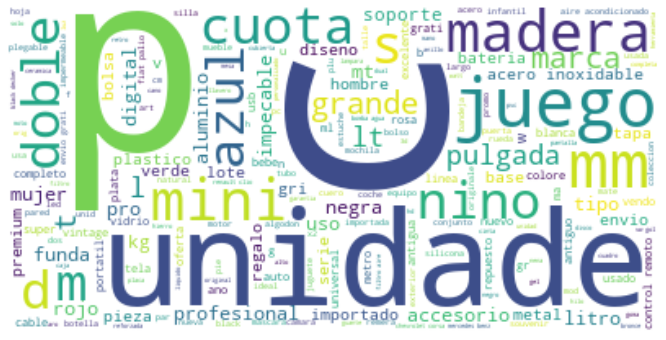

In [15]:
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=(18,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

✔ Blacklist and stopwords can be improved by checking the resulting word cloud  
✔ Some words will be preserved to let the model learn about the context of words from titles processed 

Finally, let's check the length of titles to see if some processing is required.

In [16]:
df["len_title"] = df["title"].apply(len)
df

,title,label_quality,language,category,len_title
567166,Óculos Box 2.0 3d Android Ios Controle Preço T...,unreliable,portuguese,3D_GLASSES,59
17814839,Super Óculos 3d Sony - Promoção,unreliable,portuguese,3D_GLASSES,31
18192638,Lentes 3d Importados,unreliable,spanish,3D_GLASSES,20
13037924,Hombres Mujeres Gafas De Protección Moda Prote...,unreliable,spanish,3D_GLASSES,59
3732721,3 X Lentes Clip-on 3d Cinema Sobrepor Oculos D...,unreliable,portuguese,3D_GLASSES,60
...,...,...,...,...,...
10562776,Yogurtera Antigua Batilux Con Caja Y Manual,unreliable,spanish,YOGURT_MAKERS,43
10653564,Cuotas S/int! Yogurtera Atma Ym3010e Digital 7...,unreliable,spanish,YOGURT_MAKERS,59
19907444,"Iogurteira Elétrica 1,6 Lts 220v Com Detalhe L...",unreliable,portuguese,YOGURT_MAKERS,59
6386938,Yogurtera Mackenna,unreliable,spanish,YOGURT_MAKERS,18


<AxesSubplot:xlabel='len_title', ylabel='Count'>

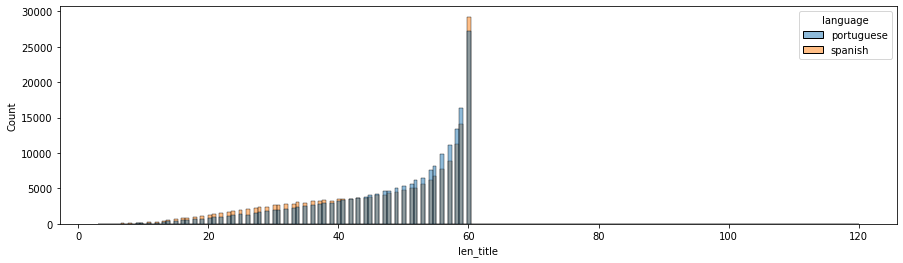

In [17]:
plt.figure(figsize=(15,4))
sns.histplot(x="len_title", hue="language", data=df, bins=200,)

<AxesSubplot:xlabel='len_title', ylabel='language'>

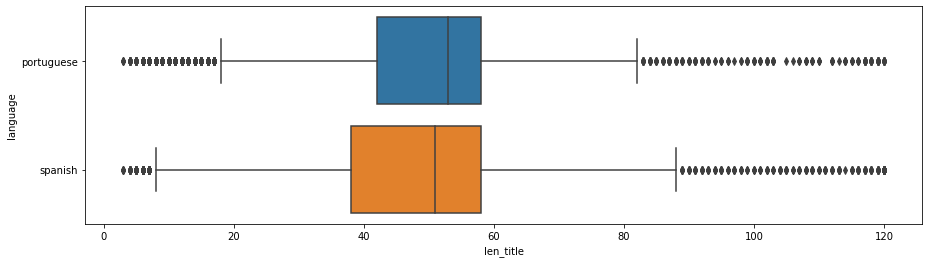

In [18]:
plt.figure(figsize=(15,4))
sns.boxplot(x="len_title", y="language", data=df)

In [19]:
# Check in terms of a quantile
np.quantile(df["len_title"], 0.9)

60.0

✔ For both languages, the usual lenght of titles is around 60 chars, so a trim could be a good way to limit the words to process (assuming that the first words are enough to describe the item).

## Conclusions

✔ All the columns were analyzed to understand the information available  
✔ Aspects about preparation of text and categories were defined  
✔ An strategy for cross-validation was defined  
✔ An specification of the processing to do was obtained (documented in `docs/notes.md`)  